In [1]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from IPython.display import HTML
from torchvision import models
from scipy import linalg
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import time

In [2]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
dataset = datasets.CIFAR10(root="HW4/dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


cuda


100%|██████████| 170M/170M [00:02<00:00, 61.7MB/s] 


Extracting HW4/dataset/CIFAR10data/cifar-10-python.tar.gz to HW4/dataset/CIFAR10data


In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,shuffle=True, num_workers=2)
real_batch = next(iter(dataloader))
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.net(x)


In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self.Dnet(features_d, features_d * 2, 4, 2, 1),
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)
  

In [6]:
gen = Generator(channels_noise = 100, channels_img = 3, features_g = 64).to(device)
disc = Discriminator(channels_img = 3, features_d = 64).to(device)

In [7]:
for m in gen.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
for m in disc.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
leaning_rate = 2e-4
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, 100, 1, 1).to(device)
step = 0

In [12]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
		'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))
            for param in self.parameters():
                param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

In [13]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

/home/pjujjav/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pjujjav/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    active=np.empty((len(images), dims))
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    predicted = model(batch)[0]
    if predicted.size(2) != 1 or predicted.size(3) != 1:
        predicted = adaptive_avg_pool2d(predicted, output_size=(1, 1))
    active= predicted.cpu().data.numpy().reshape(predicted.size(0), -1)    
    mean = np.mean(active, axis=0)
    sigma = np.cov(active, rowvar=False)
    return mean, sigma

In [15]:
def calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake, eps=1e-6):
    sigma_real = np.atleast_2d(sigma_real)
    sigma_fake = np.atleast_2d(sigma_fake)
    mu_real = np.atleast_1d(mu_real)
    mu_fake = np.atleast_1d(mu_fake)
    assert mu_real.shape == mu_fake.shape, \
        'Real and fake mean vectors have different lengths'
    assert sigma_real.shape == sigma_fake.shape, \
        'Real and fake covariances have different dimensions'
    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('FID calculation produces singular product; '
               'adding {} to diagonal of cov estimates').format(eps)
        print(msg)
        offset = np.eye(sigma_real.shape[0]) * eps
        covmean = linalg.sqrtm((sigma_real + offset).dot(sigma_fake + offset))
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    tr_covmean = np.trace(covmean)
    return (diff.dot(diff) + np.trace(sigma_real) + np.trace(sigma_fake) - 2 * tr_covmean)


In [16]:
def calculate_fretchet(real_images, fake_images, model):
    mu_real, std_real = calculate_activation_statistics(real_images, model, cuda=True)
    mu_fake, std_fake = calculate_activation_statistics(fake_images, model, cuda=True)
    fd_value = calculate_frechet_distance(mu_real, std_real, mu_fake, std_fake)
    return fd_value

In [17]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [18]:
GLoss = []
DLoss = []
image_list = []
fd_list = []
i = 0

gen_optimizer = optim.Adam(gen.parameters(), lr=leaning_rate, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(disc.parameters(), lr=leaning_rate, betas=(0.5, 0.999))

In [19]:
print("!!Training Started!!")
time_start = time.time()
num_epochs = 50
for epoch in range(num_epochs):
    epoch = epoch+1

    for batch_idx, data in enumerate(dataloader,0):
        #training with real batch
        real = data[0].to(device)
        noise = torch.randn(128, 100, 1, 1).to(device)
        fake = gen(noise) #genrator img data

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        disc_optimizer.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                    f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                      Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f}"
                )
            #saving the losses for every 100 batch
            GLoss.append(loss_gen.detach().cpu())
            DLoss.append(loss_disc.detach().cpu())
                    # Check how the generator is doing by saving G's output on fixed_noise
        if (i % 500 == 0) or ((epoch == num_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            image_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        i += 1
    fretchet_dist = calculate_fretchet(real, fake, model)
    print('Fretchet Distance: ', fretchet_dist)
    fd_list.append(fretchet_dist)


!!Training Started!!
Epoch [1/50] Batch 0/1563                       Loss Discriminator: 0.693, loss Generator: 0.703
Epoch [1/50] Batch 100/1563                       Loss Discriminator: 0.171, loss Generator: 2.986
Epoch [1/50] Batch 200/1563                       Loss Discriminator: 0.276, loss Generator: 2.165
Epoch [1/50] Batch 300/1563                       Loss Discriminator: 0.265, loss Generator: 1.804
Epoch [1/50] Batch 400/1563                       Loss Discriminator: 0.262, loss Generator: 2.361
Epoch [1/50] Batch 500/1563                       Loss Discriminator: 0.517, loss Generator: 1.524
Epoch [1/50] Batch 600/1563                       Loss Discriminator: 0.912, loss Generator: 3.898
Epoch [1/50] Batch 700/1563                       Loss Discriminator: 0.560, loss Generator: 1.254
Epoch [1/50] Batch 800/1563                       Loss Discriminator: 0.463, loss Generator: 1.210
Epoch [1/50] Batch 900/1563                       Loss Discriminator: 0.712, loss Generato

In [26]:
time_end = time.time()
print('elapsed time：%.2f s.'%(time_end-time_start))

elapsed time：2666.20 s.


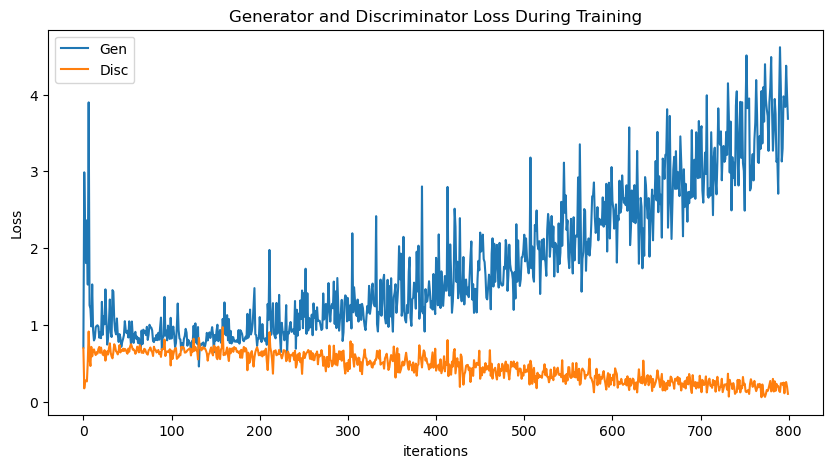

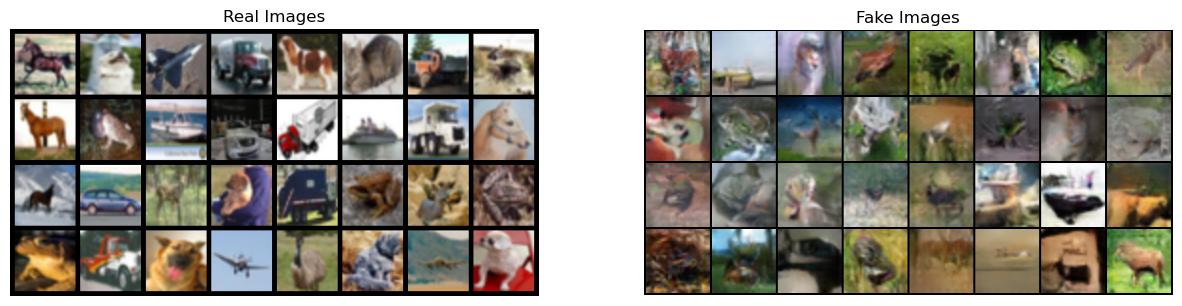

In [27]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GLoss,label="Gen")
plt.plot(DLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(image_list[-1],(1,2,0)))
plt.savefig('compare.png')
plt.show()

In [28]:
print (gen)

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, 